# Data

In [ ]:
#| default_exp data

In [ ]:
#| export

from dreamai_dl.imports import *
from dreamai_dl.utils import *

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
#| export

def split_df(train_df, test_size=0.15, stratify_idx=1):
    try:    
        train_df,test_df = train_test_split(train_df, test_size=test_size, stratify=train_df.iloc[:,stratify_idx])
    except:
        print('Not stratified.')
        train_df,test_df = train_test_split(train_df, test_size=test_size)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    return train_df,test_df

def get_data_stats(df, data_path='', img_idx=0, img_size=224, channels=3, stats_percentage=0.7, bs=32, num_workers=4, device=None):
    "Calculates the mean and std of a dataset."
    
    if device is None:
        device = default_device()
    print('Calculating dataset mean and std. This may take a while.\n')
    frac_data = df.copy().sample(frac=stats_percentage).reset_index(drop=True).copy()
    if list_or_tuple(img_size):
        img_size = img_size[0]
    tfms = transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()])
    dset = StatsDataset(frac_data, data_path=data_path, tfms=tfms, img_idx=img_idx, channels=channels)
    dl = DataLoader(dset, batch_size=bs, num_workers=num_workers)
    batches = len(dl)
    mean = 0.0
    print('Mean loop:')
    for i,data_batch in enumerate(dl):
        try:
            if i % (batches//10) == 0:
                print(f'Batch: {i+1}/{batches}')
        except:
            print(f'Batch: {i+1}/{batches}')
        # images = data_batch[0]
        if is_list(data_batch['image']):
            images = data_batch['image'][0].to(device)
        else:
            images = data_batch['image'].to(device)
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.to(dtype=torch.float32).mean(2).sum(0)
    mean = mean / len(dl.dataset)
    var = 0.0
    print('\nStd loop:')
    for i,data_batch in enumerate(dl):
        try:
            if i % (batches//10) == 0:
                print(f'Batch: {i+1}/{batches}')
        except:
            print(f'Batch: {i+1}/{batches}')
        # images = data_batch[0]
        if is_list(data_batch['image']):
            images = data_batch['image'][0].to(device)
        else:
            images = data_batch['image'].to(device)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    std = torch.sqrt(var / (len(dl.dataset)*img_size*img_size))
    print('\nDone.')
    return mean.cpu(), std.cpu()

class StatsDataset(Dataset):
    "Dataset for calculating mean and std of a dataset."
    def __init__(self, data, data_path='', img_idx=0, tfms=None, channels=3, **kwargs):
        super().__init__()
        if tfms is None:
            tfms = transforms.Compose([transforms.ToTensor()])
        data_path = Path(data_path)
        store_attr(','.join(dict_keys(locals_to_params(locals()))))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = Image.open(self.data_path/self.data.iloc[index, self.img_idx])
        if self.channels == 1:
            img = img.convert('L')
        else:
            img = img.convert('RGB')
        return {'image': self.tfms(img)}

class SLDataset(Dataset):
    "Dataset for single label classification."
    def __init__(self, data, data_path='', tfms=None, img_idx=0, label_idx=1, channels=3, class_names=None, **kwargs):
        super().__init__()
        
        data_path = Path(data_path)
        if class_names is None:
            class_names = np.unique(data.iloc[:, label_idx])
        idx_to_class = dict(enumerate(class_names))
        class_to_idx = {v:k for k,v in idx_to_class.items()}
             
        store_attr(','.join(dict_keys(locals_to_params(locals()))))
        
    def __len__(self):
        return len(self.data)
    
    def get_img_name(self, index):
        # return [self.data.iloc[index, x] for x in self.img_idx]
        return self.data.iloc[index, self.img_idx]
    
    def get_img_path(self, index):
        return str(self.data_path/self.get_img_name(index))
        # return [str(self.data_path/x) for x in self.get_img_names(index)]
        
    def get_img(self, index):
        img = Image.open(self.get_img_path(index))
        if self.channels == 1:
            return img.convert('L')
        return img.convert('RGB')
        # return [Image.open(x).convert('RGB') for x in self.get_img_paths(index)]
    
    def get_tensor(self, index, to_tensor=True):
        img = self.get_img(index)
        if self.tfms is not None:
            x = self.tfms(copy.deepcopy(img))
            # if self.channels == 1:
                # x.unsqueeze_(0)
            if not to_tensor:
                x = tensor_to_img(x)
        else:
            x = img
        return x
    
    def get_label(self, index, get_idx=True):
        if get_idx:
            return self.class_to_idx[self.data.iloc[index, self.label_idx]]
            # return [cid[self.data.iloc[index, x]] for cid,x in zip(self.class_to_idx,self.label_idx)]
        return self.data.iloc[index, self.label_idx]
        # return [self.data.iloc[index, x] for x in self.label_idx]

    def __getitem__(self, index, to_tensor=True, get_idx=True, get_name=False, get_path=False):
        ret = {'image':self.get_tensor(index, to_tensor=to_tensor), 'label':self.get_label(index, get_idx=get_idx)}
        if get_name:
            ret['image_name'] = self.get_img_name(index)
        if get_path:
            ret['image_path'] = self.get_img_path(index)
        return ret

    # def denorm_data(self, data, keys=['images']):
    #     if self.tfms is not None:
    #         norm_t = get_norm(self.tfms)
    #         if norm_t:
    #             mean = norm_t.mean
    #             std = norm_t.std
    #             for k in keys:
    #                 data[k] = denorm_img(data[k], mean, std)

    def get_at_index(self, index, to_tensor=False, get_name=True, get_path=True):

        data = self.__getitem__(index, to_tensor=to_tensor, get_idx=False, get_name=get_name, get_path=get_path)
        # if denorm:
            # self.denorm_data(data=data)
        return data
    
class SLDataModule(L.LightningDataModule):
    "DataModule for single label classification."
    def __init__(self, parq_file, data_path='', train_tfms=None, test_tfms=None, train_size=0.8, valid_size=0.2, test_size=0.1,
                 img_size=512, channels=3, batch_size=64, num_workers=6, pin_memory=False, calc_stats=False, stats_img_size=224,
                 stats_file='img_stats.pkl', seed=42, **kwargs):
        super().__init__()
        L.seed_everything(seed)
        self.save_hyperparameters(ignore=['parq_file', 'data_path'])
        if is_list(img_size):
                img_size = tuple(img_size)
        test_size = test_size/valid_size
        stats_file = Path(data_path)/stats_file
        store_attr(','.join(dict_keys(locals_to_params(locals()))))

    def prepare_data(self):
        if self.calc_stats:
            df = pd.read_parquet(self.parq_file)
            self.img_mean, self.img_std = get_data_stats(df, data_path=self.data_path, img_size=self.stats_img_size,
                                                         stats_percentage=0.7, bs=64, channels=self.channels,
                                                         num_workers=self.num_workers, device='cpu')
            save_obj(self.stats_file, [self.img_mean, self.img_std])
        elif Path(self.stats_file).exists() and get_norm(self.train_tfms) is None:
            self.img_mean, self.img_std = load_obj(self.stats_file)
        elif get_norm(self.train_tfms) is not None:
            norm = get_norm(self.train_tfms)
            self.img_mean, self.img_std = norm.mean, norm.std
        else:
            self.img_mean, self.img_std = imagenet_stats
        if self.train_tfms is None:
            self.train_tfms = create_transform(input_size=self.img_size, is_training=True)
        if self.test_tfms is None:
            self.test_tfms = create_transform(input_size=self.img_size)
        
        update_norm(self.train_tfms, self.img_mean, self.img_std)
        update_norm(self.test_tfms, self.img_mean, self.img_std)
    
    def setup(self, stage=None):
        df = pd.read_parquet(self.parq_file)
        train_df, valid_df = split_df(df, test_size=self.valid_size)
        valid_df, test_df = split_df(valid_df, test_size=self.test_size)
        self.train_ds = SLDataset(train_df, data_path=self.data_path, tfms=self.train_tfms, channels=self.channels)
        self.valid_ds = SLDataset(valid_df, data_path=self.data_path, tfms=self.test_tfms, channels=self.channels)
        self.test_ds = SLDataset(test_df, data_path=self.data_path, tfms=self.test_tfms, channels=self.channels)
        self.class_names = self.train_ds.class_names
        self.num_classes = len(self.class_names)
        self.idx_to_class = self.train_ds.idx_to_class

    def train_dataloader(self):
        return DataLoader(dataset=self.train_ds, batch_size=self.batch_size, drop_last=True,
                          shuffle=True, num_workers=self.num_workers, pin_memory=self.pin_memory)
    def val_dataloader(self):
        return DataLoader(dataset=self.valid_ds, batch_size=self.batch_size, drop_last=False,
                          shuffle=False, num_workers=self.num_workers, pin_memory=self.pin_memory)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_ds, batch_size=self.batch_size, drop_last=False,
                          shuffle=False, num_workers=self.num_workers, pin_memory=self.pin_memory)

## Usage

In [ ]:
data_path = Path('../img_data/')
imgs_path = data_path/'images'
parq_file = data_path/'data.parquet'
img_size = 512
channels = 1
batch_size = 4

In [ ]:
# CALCULATE STATS

train_tfms = create_transform(img_size, color_jitter=None, hflip=0.5, vflip=0.5,
                              is_training=True, mean=[1,2,3], std=[4,5,6])

test_tfms = create_transform(img_size, mean=[1,2,3], std=[4,5,6])

dm = SLDataModule(parq_file, data_path=data_path, img_size=img_size, batch_size=batch_size,
                  train_tfms=train_tfms, test_tfms=test_tfms, channels=channels, num_workers=6, calc_stats=True)
dm.prepare_data()
dm.train_tfms

Global seed set to 42


Calculating dataset mean and std. This may take a while.

Mean loop:
Batch: 1/1

Std loop:
Batch: 1/1

Done.


Compose(
    RandomResizedCropAndInterpolation(size=(512, 512), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.7367]), std=tensor([0.4174]))
)

In [ ]:
dm.setup()

In [ ]:
tb = next_batch(dm.train_dataloader())
img = tb['image'][0]

In [ ]:
tb['image'].shape, img.shape

(torch.Size([4, 1, 512, 512]), torch.Size([1, 512, 512]))

In [ ]:
preds = [f'Label: {l}\nClass: {dm.idx_to_class[int(l)]} Columns' for l in tb['label']]
preds

['Label: 1\nClass: 2 Columns',
 'Label: 0\nClass: 1 Columns',
 'Label: 1\nClass: 2 Columns',
 'Label: 2\nClass: 3 Columns']

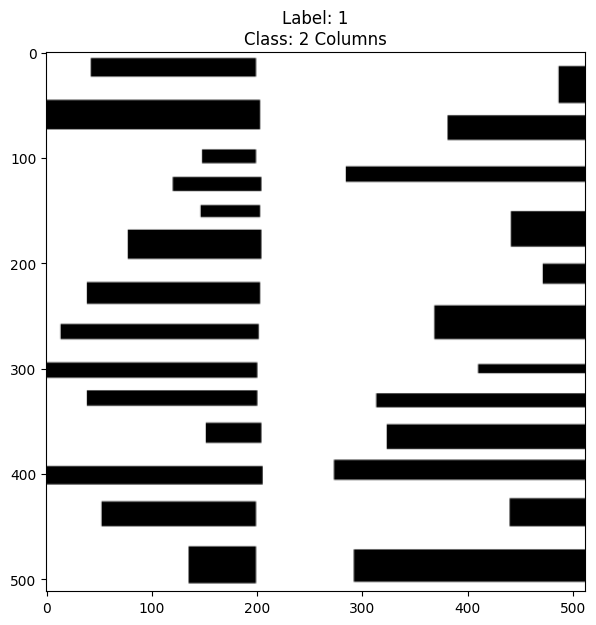

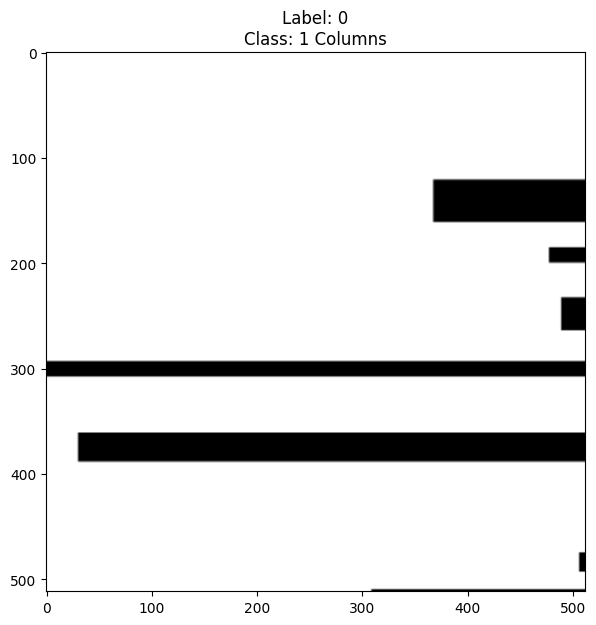

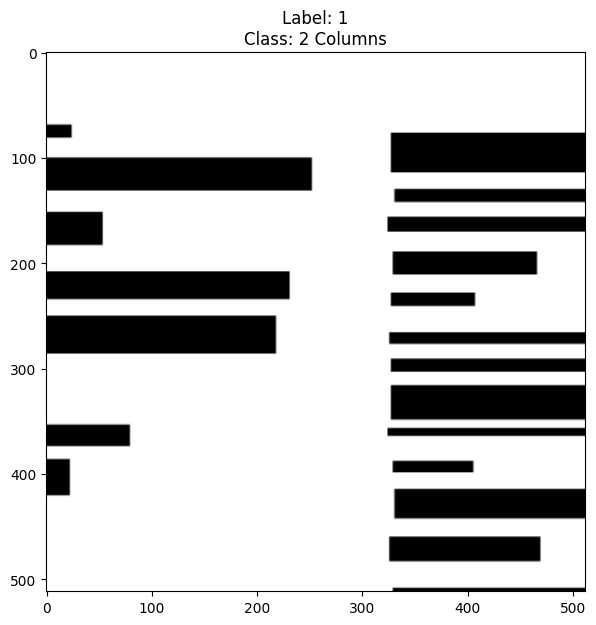

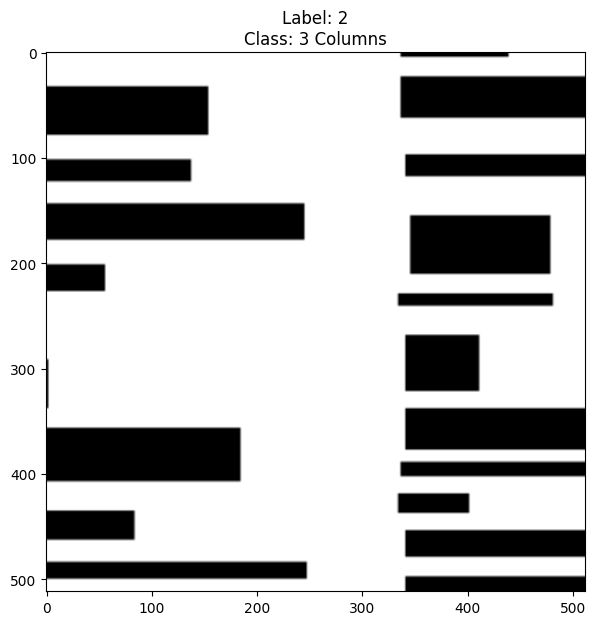

In [ ]:
show_img([img for img in tb['image']], cmap='gray', titles=preds)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()